In [1]:
%%capture output
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
import tensorflow as tf
import datetime
# 动态分配 GPU 内存
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
# 运行时间
run_time = datetime.datetime.now().strftime('%Y%m%d%H%M%S')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 数据集路径
train_data_dir = r'D:\my_deeplearn\image_classify_sdwebui\data\train'
TRAINING_LOGS_FILE = f"{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}.csv"
# 图片尺寸 224，224 更改为 224，448
img_width, img_height = 224, 448
# 超参数 32 更改为 50
batch_size = 50
# 30 更改为 20
epochs = 30
# 数据增强
train_datagen = ImageDataGenerator(
    rotation_range=10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    rescale=1./255,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.2,
)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(
                                                        img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    subset='training')
# color_mode="grayscale")
validation_generator = train_datagen.flow_from_directory(train_data_dir,
                                                         target_size=(
                                                             img_width, img_height),
                                                         batch_size=batch_size,
                                                         class_mode='binary',
                                                         subset='validation')
#  color_mode="grayscale")

Found 26293 images belonging to 2 classes.
Found 6572 images belonging to 2 classes.


In [4]:
from sklearn.utils import class_weight
import numpy as np

# 计算类别权重
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
# 将权重转换为字典格式
class_weight_dict = dict(enumerate(weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 0.6059132598976817, 1: 2.8604221061792865}


In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
# 导入VGG16模型
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(img_width, img_height, 3))
# # 使用预训练的ResNet-50模型进行迁移学习
# base_model = ResNet50(weights='imagenet', include_top=False,
#                       input_shape=(img_width, img_height, 3))
# 添加全局平均池化层和全连接层
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# 多分类
# predictions = Dense(1, activation='softmax')(x)
predictions = Dense(1, activation='sigmoid')(x)
# 构建最终模型
model = Model(inputs=base_model.input, outputs=predictions)
# 冻结预训练模型的层
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-2:]:
    layer.trainable = True


# 编译模型
model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])

c:\ProgramData\anaconda3\envs\tf-39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [6]:
import os
# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=np.ceil(len(train_generator.filenames) / batch_size),
    validation_data=validation_generator,
    validation_steps=np.ceil(len(validation_generator.filenames) / batch_size),
    epochs=epochs,
    verbose=2,
    class_weight=class_weight_dict)

model_path = os.path.join("models", f"model_{run_time}.h5")
# 保存模型
model.save(model_path)
# 计算最后 丢失率 准确率
eval_loss, eval_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", eval_loss)
print("Validation Accuracy:", eval_accuracy)

c:\ProgramData\anaconda3\envs\tf-39\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
526/526 - 1127s - loss: 0.6942 - accuracy: 0.6410 - val_loss: 0.5744 - val_accuracy: 0.7100
Epoch 2/30
526/526 - 1114s - loss: 0.6136 - accuracy: 0.7015 - val_loss: 0.7480 - val_accuracy: 0.6196
Epoch 3/30
526/526 - 1117s - loss: 0.5899 - accuracy: 0.7218 - val_loss: 1.1996 - val_accuracy: 0.3880
Epoch 4/30
526/526 - 1123s - loss: 0.5610 - accuracy: 0.7365 - val_loss: 1.2501 - val_accuracy: 0.4008
Epoch 5/30
526/526 - 1123s - loss: 0.5460 - accuracy: 0.7442 - val_loss: 1.1991 - val_accuracy: 0.4321
Epoch 6/30
526/526 - 1121s - loss: 0.5338 - accuracy: 0.7528 - val_loss: 1.0224 - val_accuracy: 0.4527
Epoch 7/30
526/526 - 1120s - loss: 0.5189 - accuracy: 0.7564 - val_loss: 0.6019 - val_accuracy: 0.7114
Epoch 8/30
526/526 - 1119s - loss: 0.5119 - accuracy: 0.7623 - val_loss: 0.7978 - val_accuracy: 0.6176
Epoch 9/30
526/526 - 1116s - loss: 0.5

c:\ProgramData\anaconda3\envs\tf-39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


132/132 [==============================] - 237s 2s/step - loss: 0.7925 - accuracy: 0.6639
Validation Loss: 0.792510986328125
Validation Accuracy: 0.6638770699501038


0it [00:00, ?it/s]

100%|██████████| 1000/1000 [01:26<00:00, 11.62it/s]


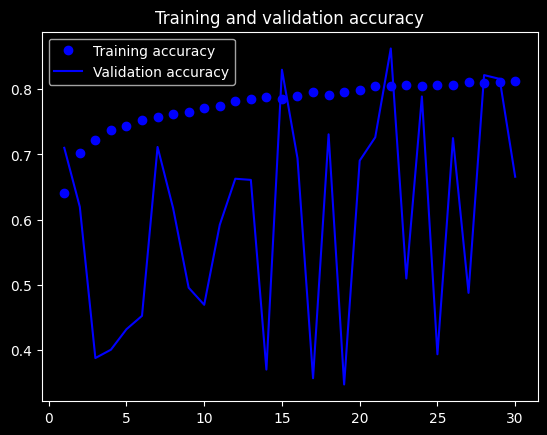

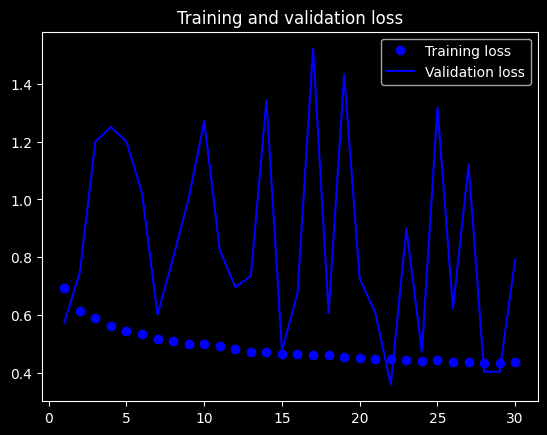

In [7]:
import json
import pandas as pd
import os
from tqdm import tqdm
from utils.utils import plt_history, walkdir, tqdm_file_count
from utils.tf_utils import preprocess_image, precision_recall
plt_history(history)
# 真是预测结果
input_shape = (img_width, img_height)
dest_dir = r'D:\my_deeplearn\image_classify_sdwebui\data\test'
base_name = os.path.basename(dest_dir)

threshold = 0.5
result_data = []
true_class_list = []
predict_class_list = []

# Preprocess the total files count
for file_path in tqdm(walkdir(dest_dir), total=tqdm_file_count(dest_dir)):
    file_dir, _ = os.path.split(file_path)
    root = os.path.basename(file_dir)
    # 获取上级目录名
    true_class = int(os.path.basename(root))
    # print(img_path)
    if not file_path.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    img_array = preprocess_image(file_path, target_size=input_shape)
    # 使用训练好的模型进行预测
    predictions = model.predict(img_array)
    if predictions[0] > threshold:
        predict_class = 1
    else:
        predict_class = 0
    result_data.append([file_path, true_class, predict_class])
    true_class_list.append(true_class)
    predict_class_list.append(predict_class)

df = pd.DataFrame(result_data, columns=[
                  "img_path", "true_class", "predict_class"])

In [8]:
csv_file = f"{base_name}_{run_time}_预测结果.csv"
df.to_csv(os.path.join("csvDir", csv_file), index=False)
precision, recall = precision_recall(true_class_list, predict_class_list)
print("Precision:", precision)
print("Recall:", recall)

# 把相关结果保存下来
with open(os.path.join("models", f"save_params_model_{run_time}.json"), "w+") as fp:
    fp.write(json.dumps({
        "width": img_width,
        "height": img_height,
        "epochs": epochs,
        "model_name": model_path,
        "eval_loss": eval_loss,
        "eval_accuracy": eval_accuracy,
        "csv_file": csv_file,
        "precision": precision,
        "Recall": recall,
        "batch_size": batch_size,
    }, ensure_ascii=False, indent=4))

Precision: 0.7016666666666667
Recall: 0.842
